In [141]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from src.data import Observation_dataset
from src.models import UNet
import data.data_dict as data_dict
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

data = data_dict.data_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### A: Dataset and Dataloader

In [149]:
# create dataset
ds = Observation_dataset(data)

100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


Shape of s2 image: torch.Size([12, 96, 96])
Shape of classes mask: torch.Size([96, 96])
Shape of rgb image: torch.Size([3, 96, 96])


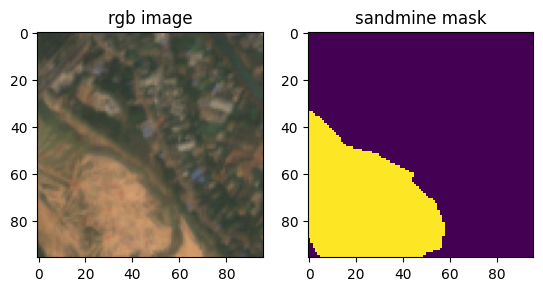

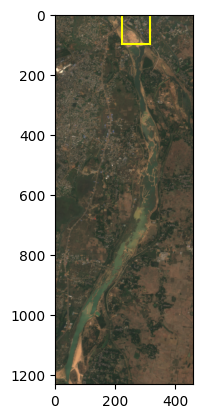

In [81]:
# check single sample
idx = 950
s2, classes, top_left_px_idx, rgb = ds.__getitem__(idx, return_rgb=True)
print(f'Shape of s2 image: {s2.shape}')
print(f'Shape of classes mask: {classes.shape}')
print(f'Shape of rgb image: {rgb.shape}')
fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(rgb.permute(1,2,0))
axs[0].set(title='rgb image')
axs[1].matshow(classes)
axs[1].set(title='sandmine mask')
plt.gca().xaxis.tick_bottom()
ds.visualize_batch([idx])

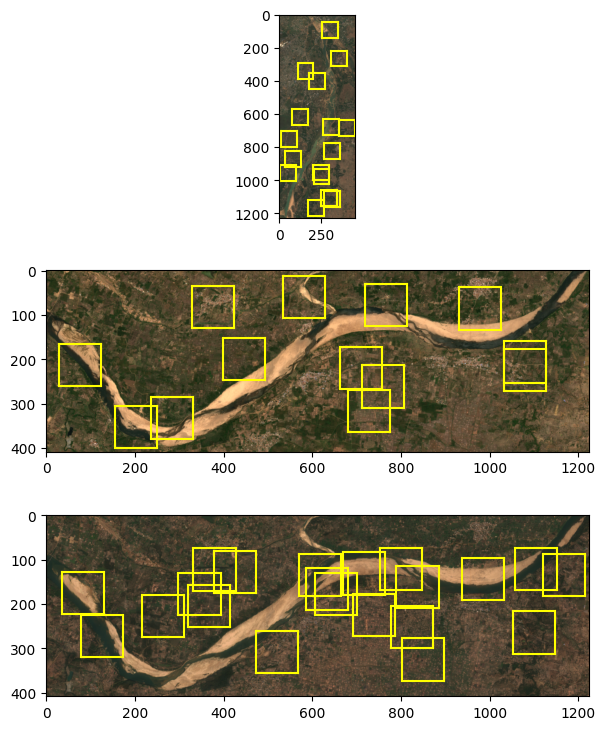

In [151]:
# check multiple samples
dl = DataLoader(ds, batch_size=50, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


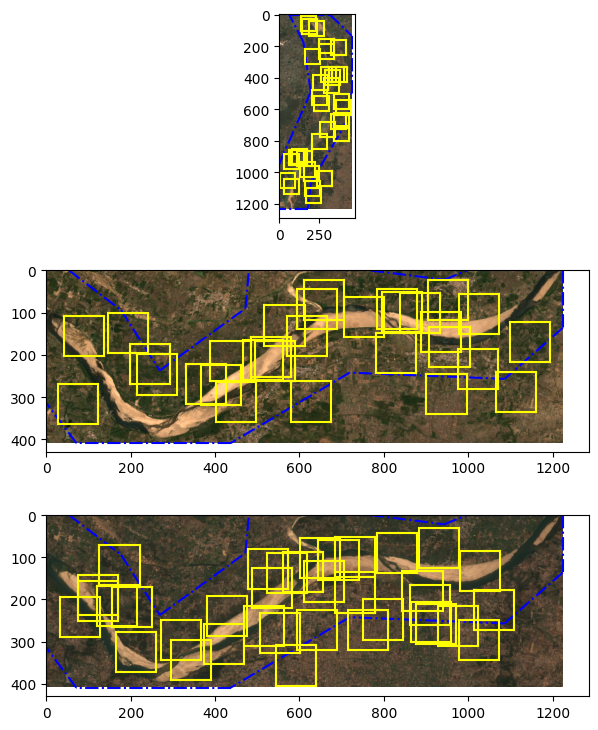

In [182]:
# stretch: only river
ds = Observation_dataset(data, only_river=True)
dl = DataLoader(ds, batch_size=100, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

### B: Semantic Segmentation Training

In [98]:
# check model output shape
ds = Observation_dataset(data[:1])
dl = DataLoader(ds, batch_size=7, shuffle=True)
model = UNet()

print(f'Number of parameters: {sum(param.numel() for param in model.parameters())}')
batch = next(iter(dl))
model.float()
out = UNet()(batch[0].float())
print(f'Output shape: {out.shape}')

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Number of parameters: 892545
Output shape: torch.Size([7, 96, 96])


In [100]:
from src.models import Pl_wrapper
from pytorch_lightning import Trainer

# Simple training loop with pytorch lightning framework
model = UNet()
dl = DataLoader(Observation_dataset(data), batch_size=32)
pl_module = Pl_wrapper(model)
trainer = Trainer(accelerator='cpu', max_epochs=1)
trainer.fit(pl_module, dl)


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lewaldm/miniforge3/envs/remote-sense/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lewaldm/miniforge3/envs/remote-sense/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name     | Type    | Params
-------------------------------------
0 | model    | UNet    | 892 K 
1 | loss_fct | BCELoss | 0     
2 | sigm     | Sigmoid | 0     
-------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.570     Total estimated model params size (MB)
/Users/lewaldm/miniforge3/envs/remote-sense/lib/python3.8/site-

Epoch 0:   0%|          | 13/35079 [00:37<28:10:00,  0.35it/s, v_num=13]

/Users/lewaldm/miniforge3/envs/remote-sense/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### C: Evaluation

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


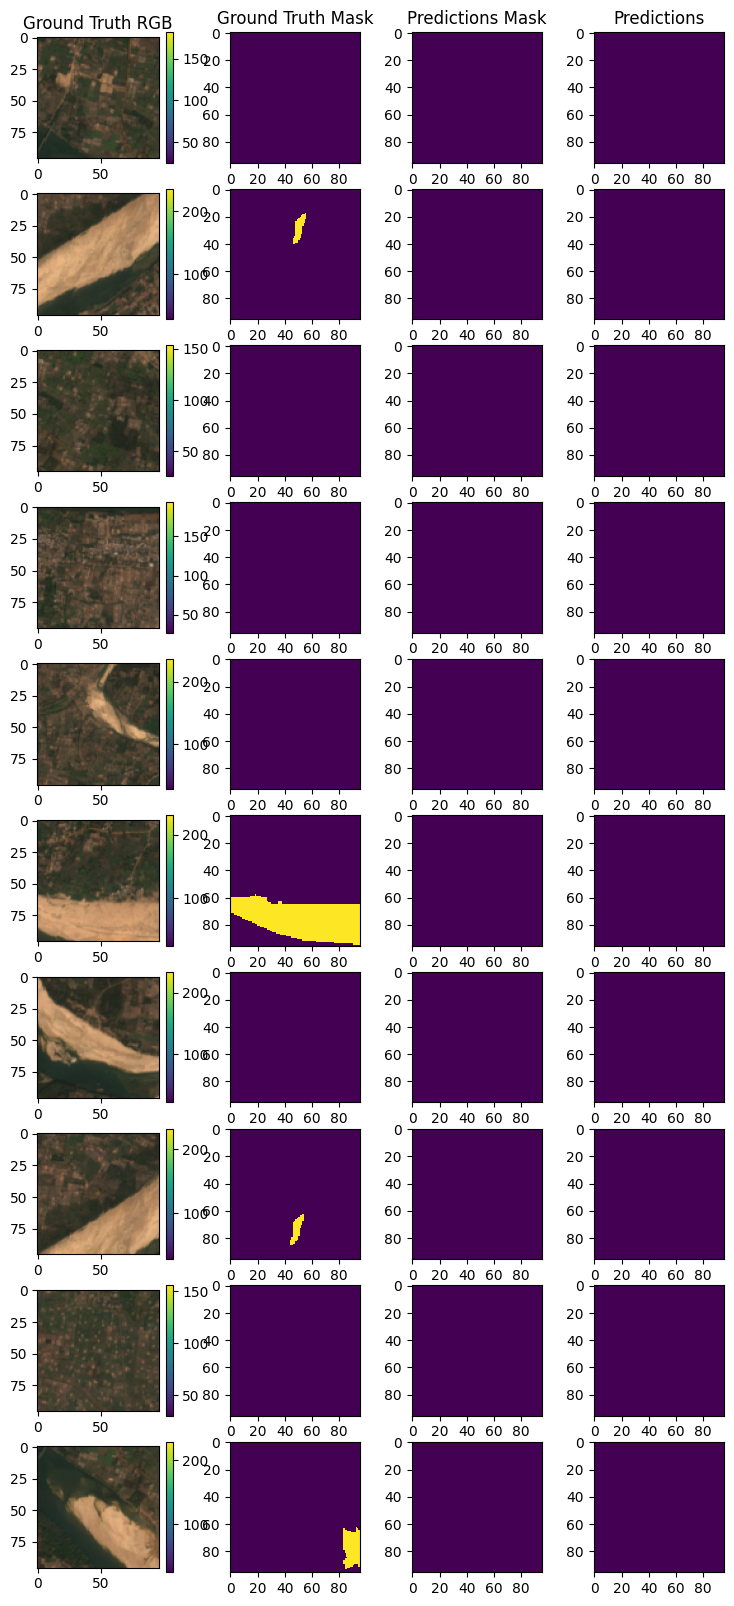

In [121]:
from torch.nn.functional import sigmoid

# params
device = 'cpu'
n_samples = 10

# load data
train_ds = Observation_dataset(data[:2])
test_ds = Observation_dataset(data[2:])
test_dl = DataLoader(test_ds, batch_size=n_samples, shuffle=True)
batch = next(iter(test_dl))

# make predictions
model.eval()
model.to(device)
with torch.no_grad():
    preds = sigmoid(model(batch[0].to(device)))
targets = batch[1]

# plotting
nrows, ncols = n_samples, 4
plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,2*nrows))
for i in range(n_samples):
    plt.subplot(nrows,ncols, ncols*i + 1)
    _,target2,_,gt_rgb = test_ds.__getitem__(batch[2][i], return_rgb=True)
    plt.imshow(gt_rgb.permute(1,2,0))
    if i == 0:
        plt.title('Ground Truth RGB')

    plt.subplot(nrows,ncols, ncols*i + 2)
    plt.gca().matshow(targets[i])
    plt.gca().xaxis.tick_bottom()
    if i == 0:
        plt.title('Ground Truth Mask')

    plt.subplot(nrows,ncols, ncols*i + 3)
    plt.gca().matshow( (preds[i] >= 0.5).int() )
    plt.gca().xaxis.tick_bottom()
    if i == 0:
        plt.title('Prediction Masks')

    plt.subplot(nrows,ncols, ncols*i + 4)
    plt.gca().matshow(preds[i])
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    if i == 0:
        plt.title('Predictions')

In [142]:
# Stretch: full image
batch_size = 64
test_dl = DataLoader(test_ds, batch_size=batch_size)
counts_all = torch.zeros(test_ds.data[0]['data_rgb'].shape[1:3])
preds_all = torch.zeros_like(counts_all)

# compute predictions
model.eval()
model.to(device)
with torch.no_grad():
    for batch in tqdm(test_dl):
        preds = sigmoid(model(batch[0].to(device)))
        for i in range(batch_size):
            _, idx_height, idx_width = test_ds._idx2obsheightwidth(batch[2][i])
            counts_all[ idx_height:idx_height+test_ds.sample_height,
                    idx_width:idx_width+test_ds.sample_width ] += 1
            preds_all[ idx_height:idx_height+test_ds.sample_height,
                    idx_width:idx_width+test_ds.sample_width ] += preds[i]  
preds_all = preds_all / counts_all 

# plotting
fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(rgb.permute(1,2,0))
axs[0].set(title='RGB Image')
axs[1].matshow(classes)
axs[1].set(title='Ground Truth Mask')
plt.gca().xaxis.tick_bottom()
axs[2].matshow((preds_all > 0.5).int())
plt.gca().xaxis.tick_bottom()

  1%|          | 57/5540 [01:17<2:04:20,  1.36s/it]


KeyboardInterrupt: 

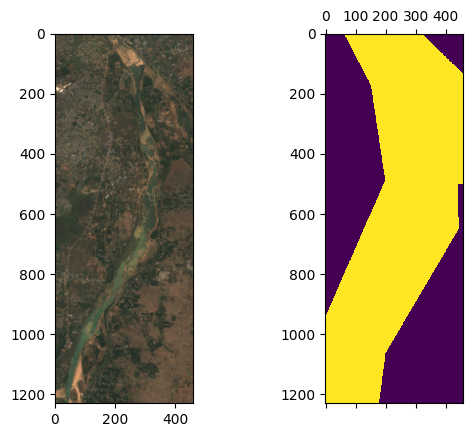

In [145]:
from rasterio.features import rasterize
import json
import rasterio
from osgeo import gdal

shapes = []
with open('/Users/lewaldm/Documents/code/Bhargavi_Khordha_85-88_20-26_rivers_1000m.geojson') as f:
    geojson = json.load(f)

s2 = rasterio.open('/Users/lewaldm/Documents/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif')

for f in geojson['features']:
    shapes.append( (f['geometry'],1))
mask = rasterize(
    shapes,
    (s2.height, s2.width),
    transform = s2.transform)

rgb = torch.from_numpy(gdal.Open('/Users/lewaldm/Documents/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb.tif').ReadAsArray())

plt.subplots(1,2)
plt.subplot(121)
plt.imshow(rgb.permute(1,2,0))
plt.subplot(122)
plt.gca().matshow(mask)